In [3]:
import proplot as plot
import numpy as np
import yaml
import glob
import copy

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "DEBUG"))

In [5]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect
from pizza_cutter_sims.stars import mask_and_interp_stars

with open(glob.glob("ref_config.yaml")[0]) as fp:
    base_cfg = yaml.safe_load(fp.read())
    
# base_cfg["se"]["n_images"] = 2
# base_cfg["pizza_cutter"]["single_epoch_config"]["spline_interp_flags"] = [7]

In [16]:
import tqdm

rng = np.random.RandomState(seed=100)
seeds = rng.randint(low=1, high=2**29, size=5)

all_msk_keys = ["bad_columns", "cosmic_rays", "streaks", "star"]
all_msk_keys = ["star"]
results = {}
for msk_key in tqdm.tqdm(["star"]):
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    star_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])
    mdet_rng = np.random.RandomState(seed=seeds[3])

    cfg = copy.deepcopy(base_cfg)
    for key in all_msk_keys:
        if key != "star":
            cfg["msk"][key] = False
    for key in all_msk_keys:
        if key == "star":
            continue
        cfg["msk"][key] = True
        if key == msk_key:
            break
    
    if msk_key == "star":
        cfg["star"]["dens_factor"] = 1
    else:
        cfg["star"]["dens_factor"] = 0

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        star_rng=star_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        star_config=cfg["star"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
        skip_coadding=False,
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            img=data["img"],
            wgt=data["wgt"],
            msk=data["msk"],
            bkg=data["bkg"],
            info=data["info"],
            n_extra_noise_images=0,
        )
        
    mask_and_interp_stars(
        cdata=cdata, 
        stars=data["stars"], 
        rng=star_rng,
        interp_cfg=cfg["star"]["interp"],
    )
    
    results[msk_key] = cdata

  0%|                                                                                                                                               | 0/1 [00:00<?, ?it/s]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=233.0, y=233.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:psf config: {'type': 'Gaussian', 'fwhm': 0.9, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:galsim psf: galsim.Gaussian(sigma=0.3821948101296086).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'exp-super-bright' gal type w/ mag 14.0
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:pre-processing image epoch

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


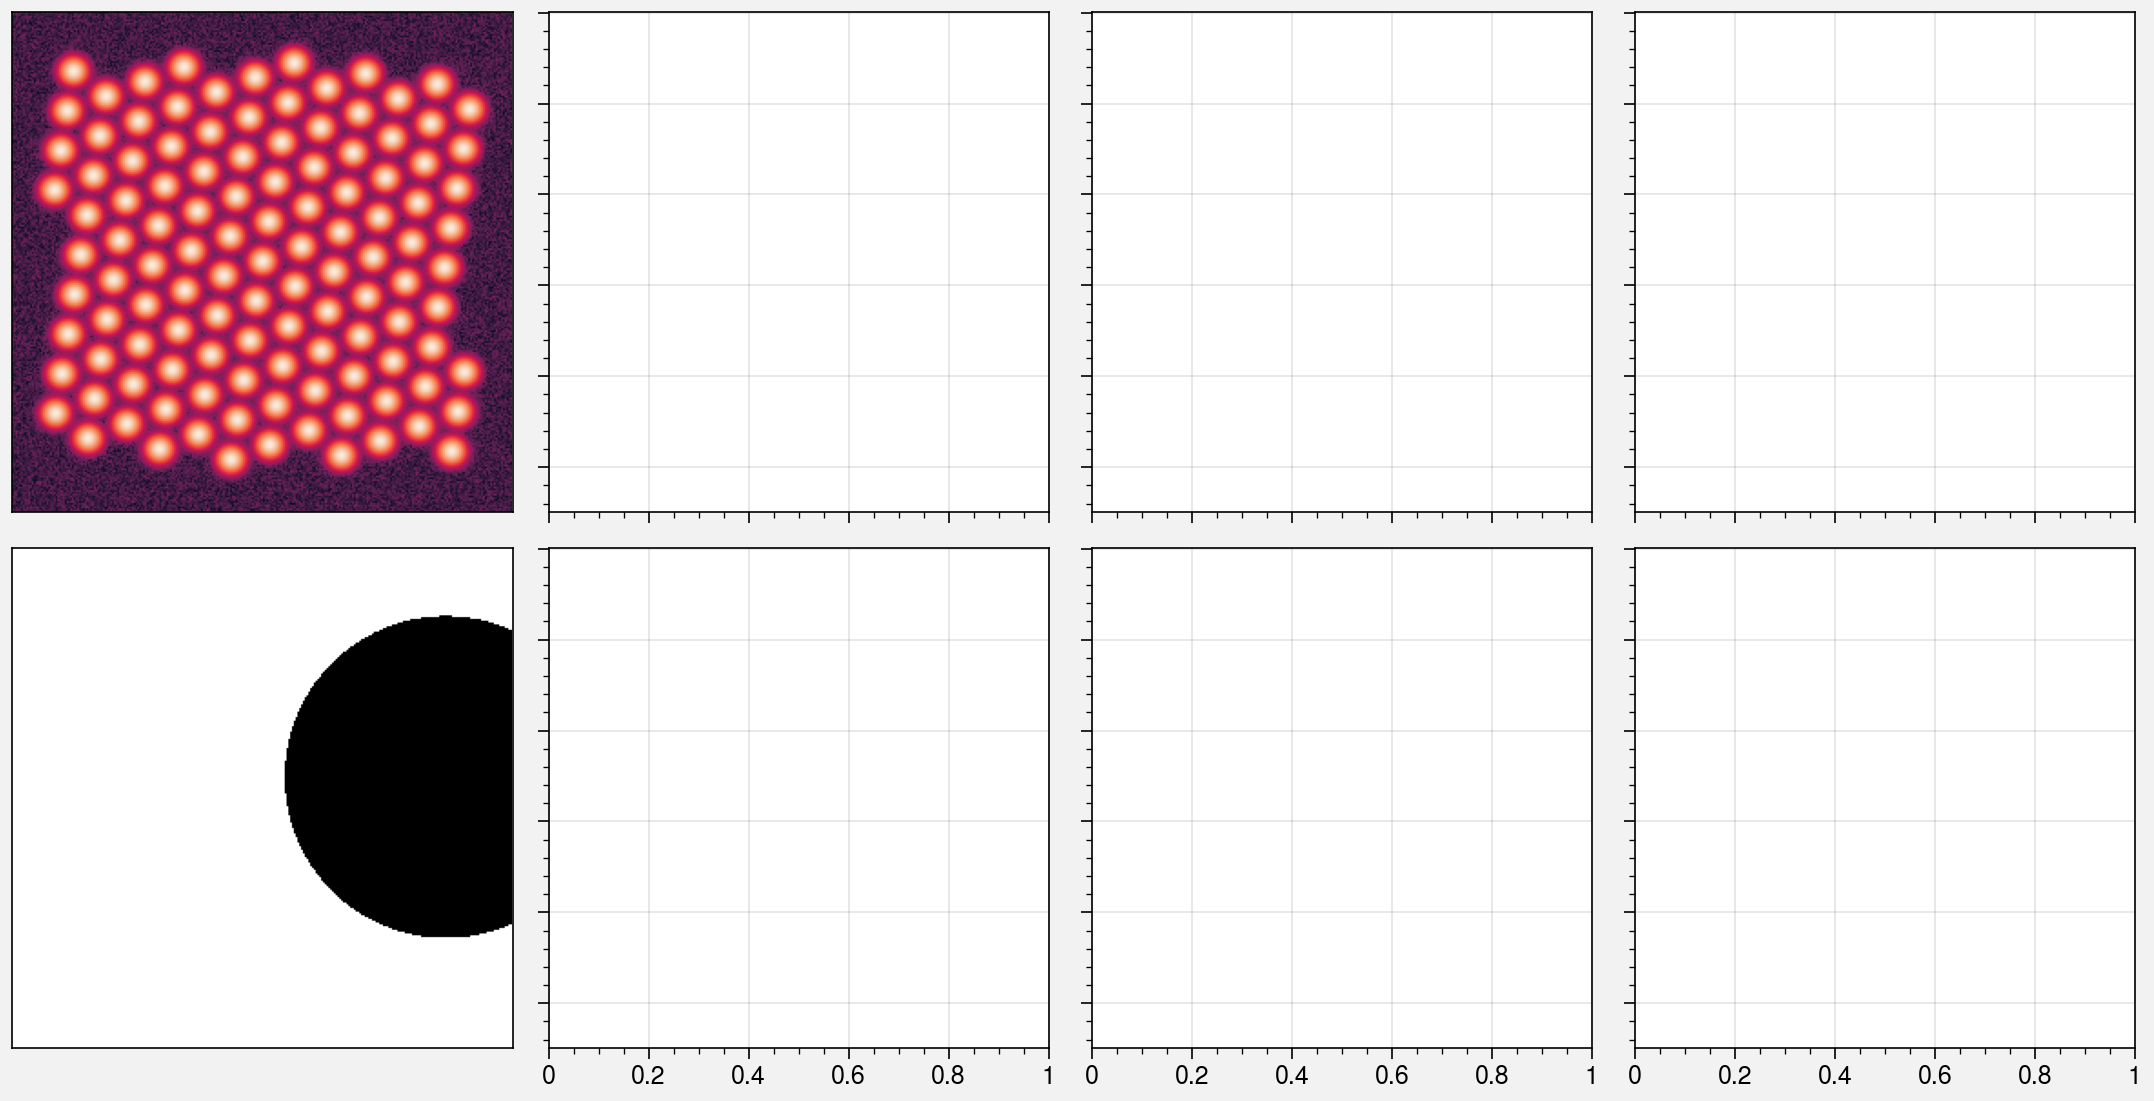

In [17]:
vmin = np.inf
vmax = -np.inf

for i, key in enumerate(all_msk_keys):
    img = results[key]["image"]
    wgt = results[key]["weight"]
    ormask = results[key]["ormask"]
    vv = np.arcsinh(img*np.sqrt(wgt))
    vmin = min(np.min(vv), vmin)
    vmax = max(np.max(vv), vmax)

fig, axs = plot.subplots(nrows=2, ncols=4, share=3)
for i, key in enumerate(all_msk_keys):
    img = results[key]["image"]
    wgt = results[key]["weight"]
    ormask = results[key]["ormask"]
    ax = axs[0, i]
    ax.imshow(np.arcsinh(img*np.sqrt(wgt)), cmap="rocket", vmin=vmin, vmax=vmax)
    ax.grid(False)
    ax.format(xtickloc='neither', ytickloc='neither')
    
    ax = axs[1, i]
    ax.imshow(ormask.astype(bool), cmap="gray_r", vmin=0, vmax=1)    
    ax.grid(False)
    ax.format(xtickloc='neither', ytickloc='neither')
    
fig.savefig("msk.png")

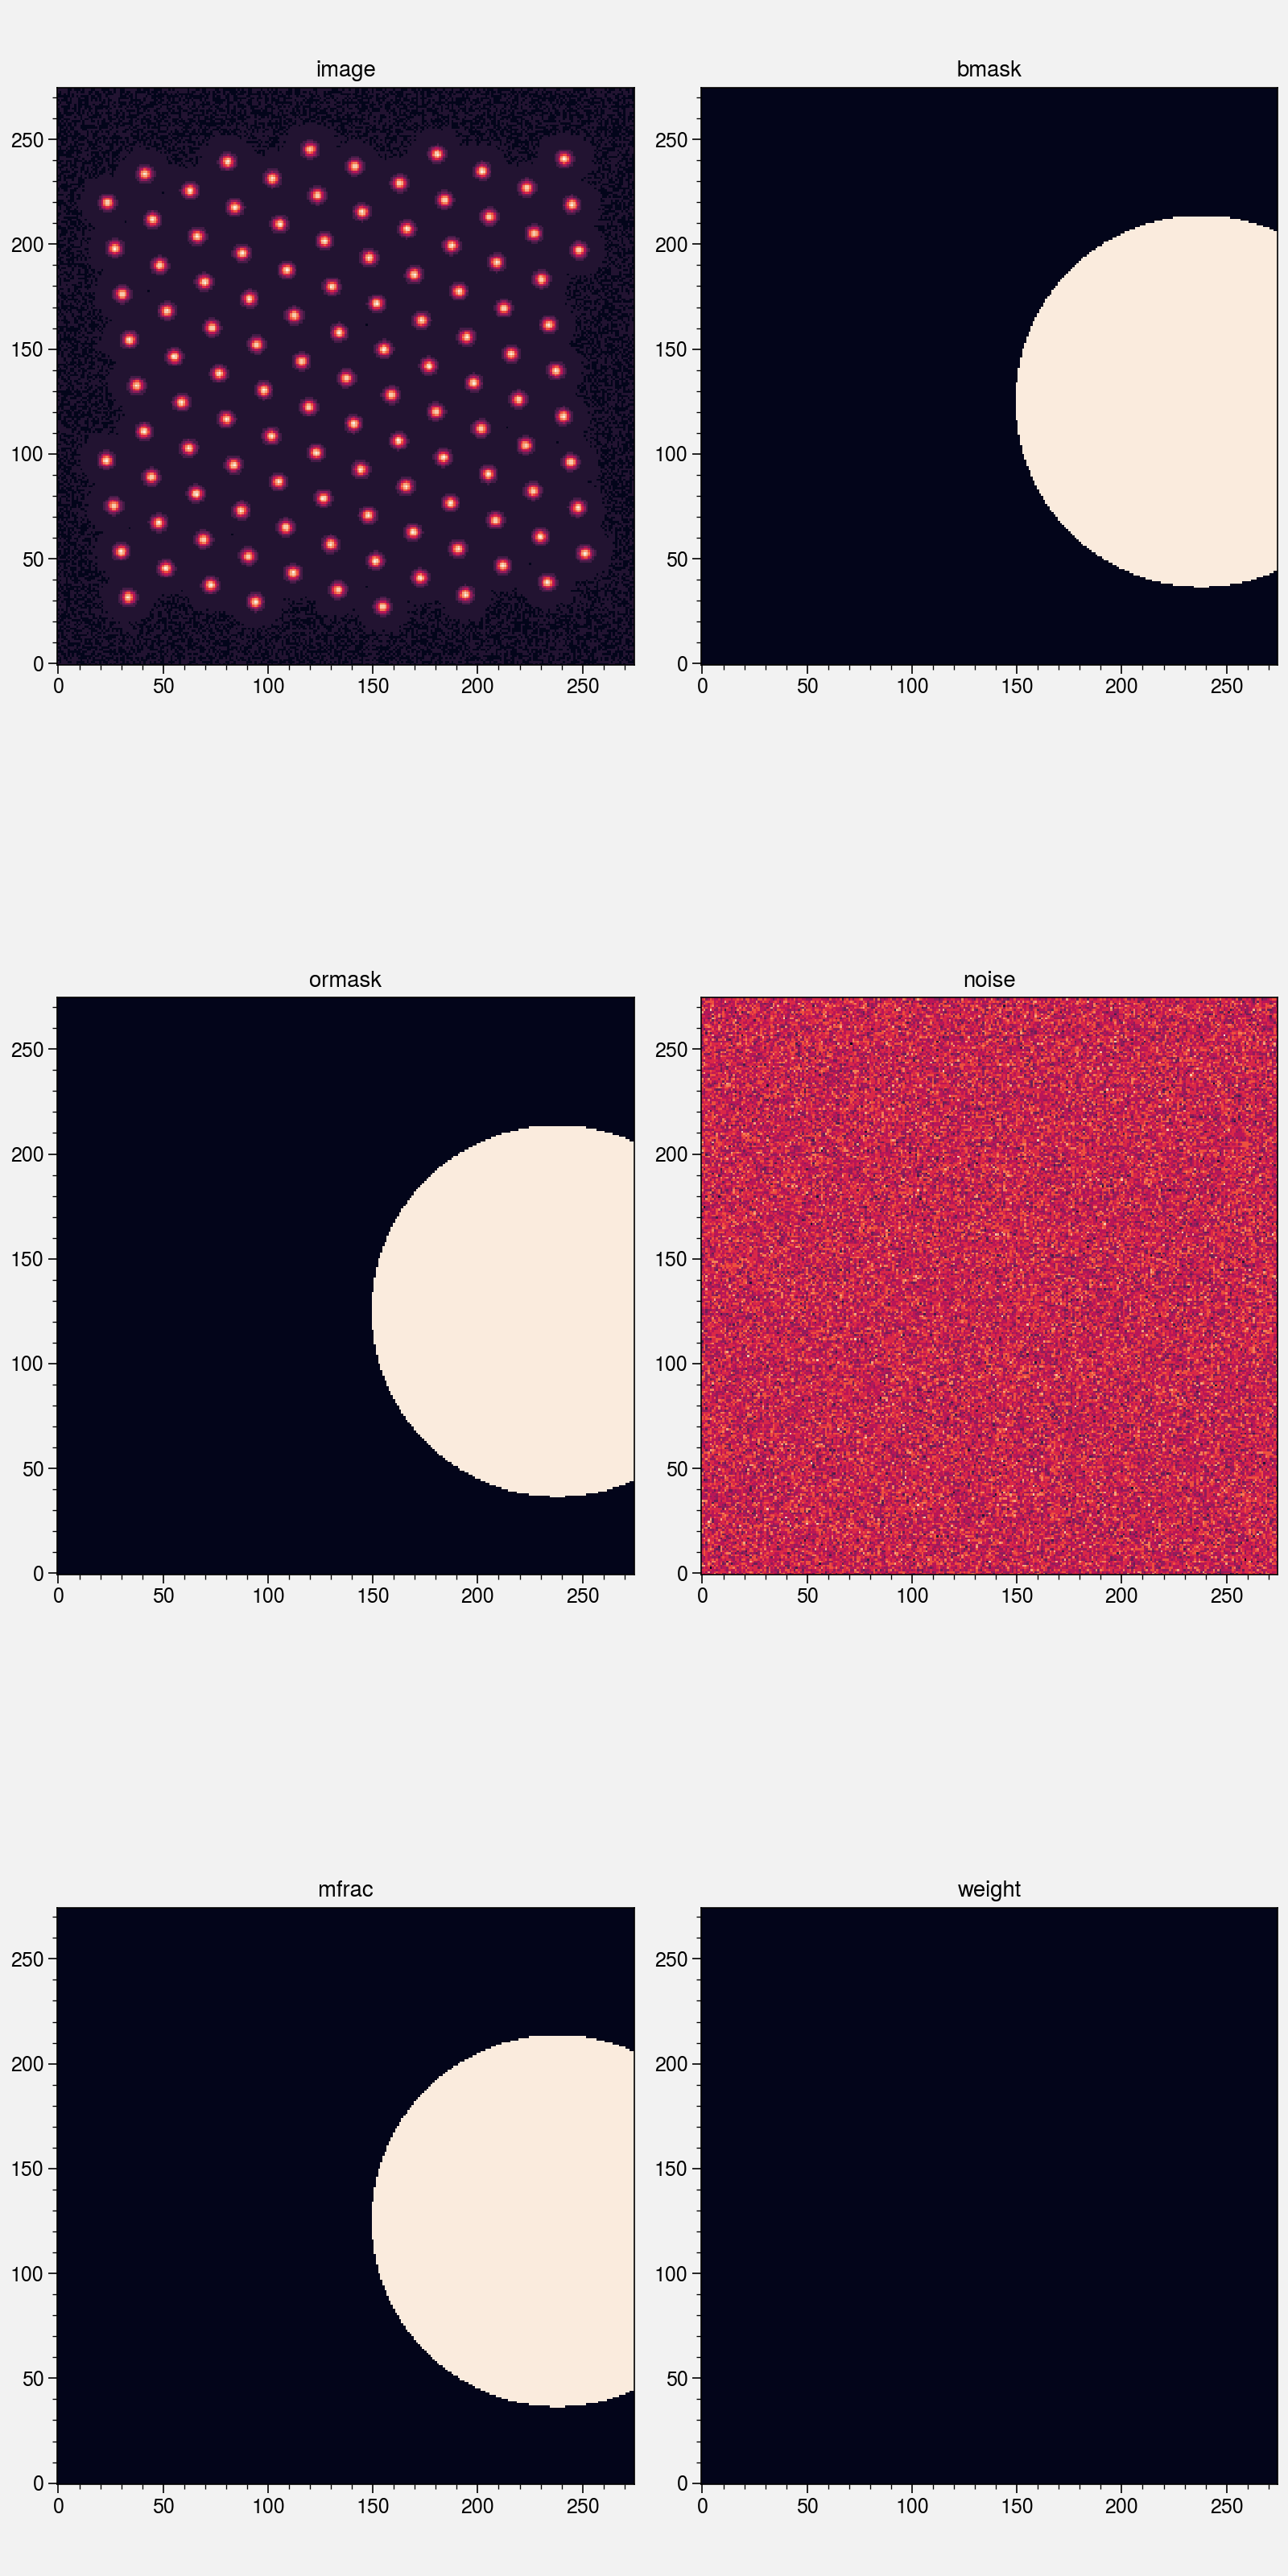

In [18]:
fig, axs = plot.subplots(nrows=3, ncols=2, figsize=(8, 16), share=0)
cdata = results["star"]

for i, key in enumerate(["image", "bmask", "ormask", "noise", "mfrac", "weight"]):
    axs[i].pcolormesh(cdata[key], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)

Text(0.5, 1.0, 'image')

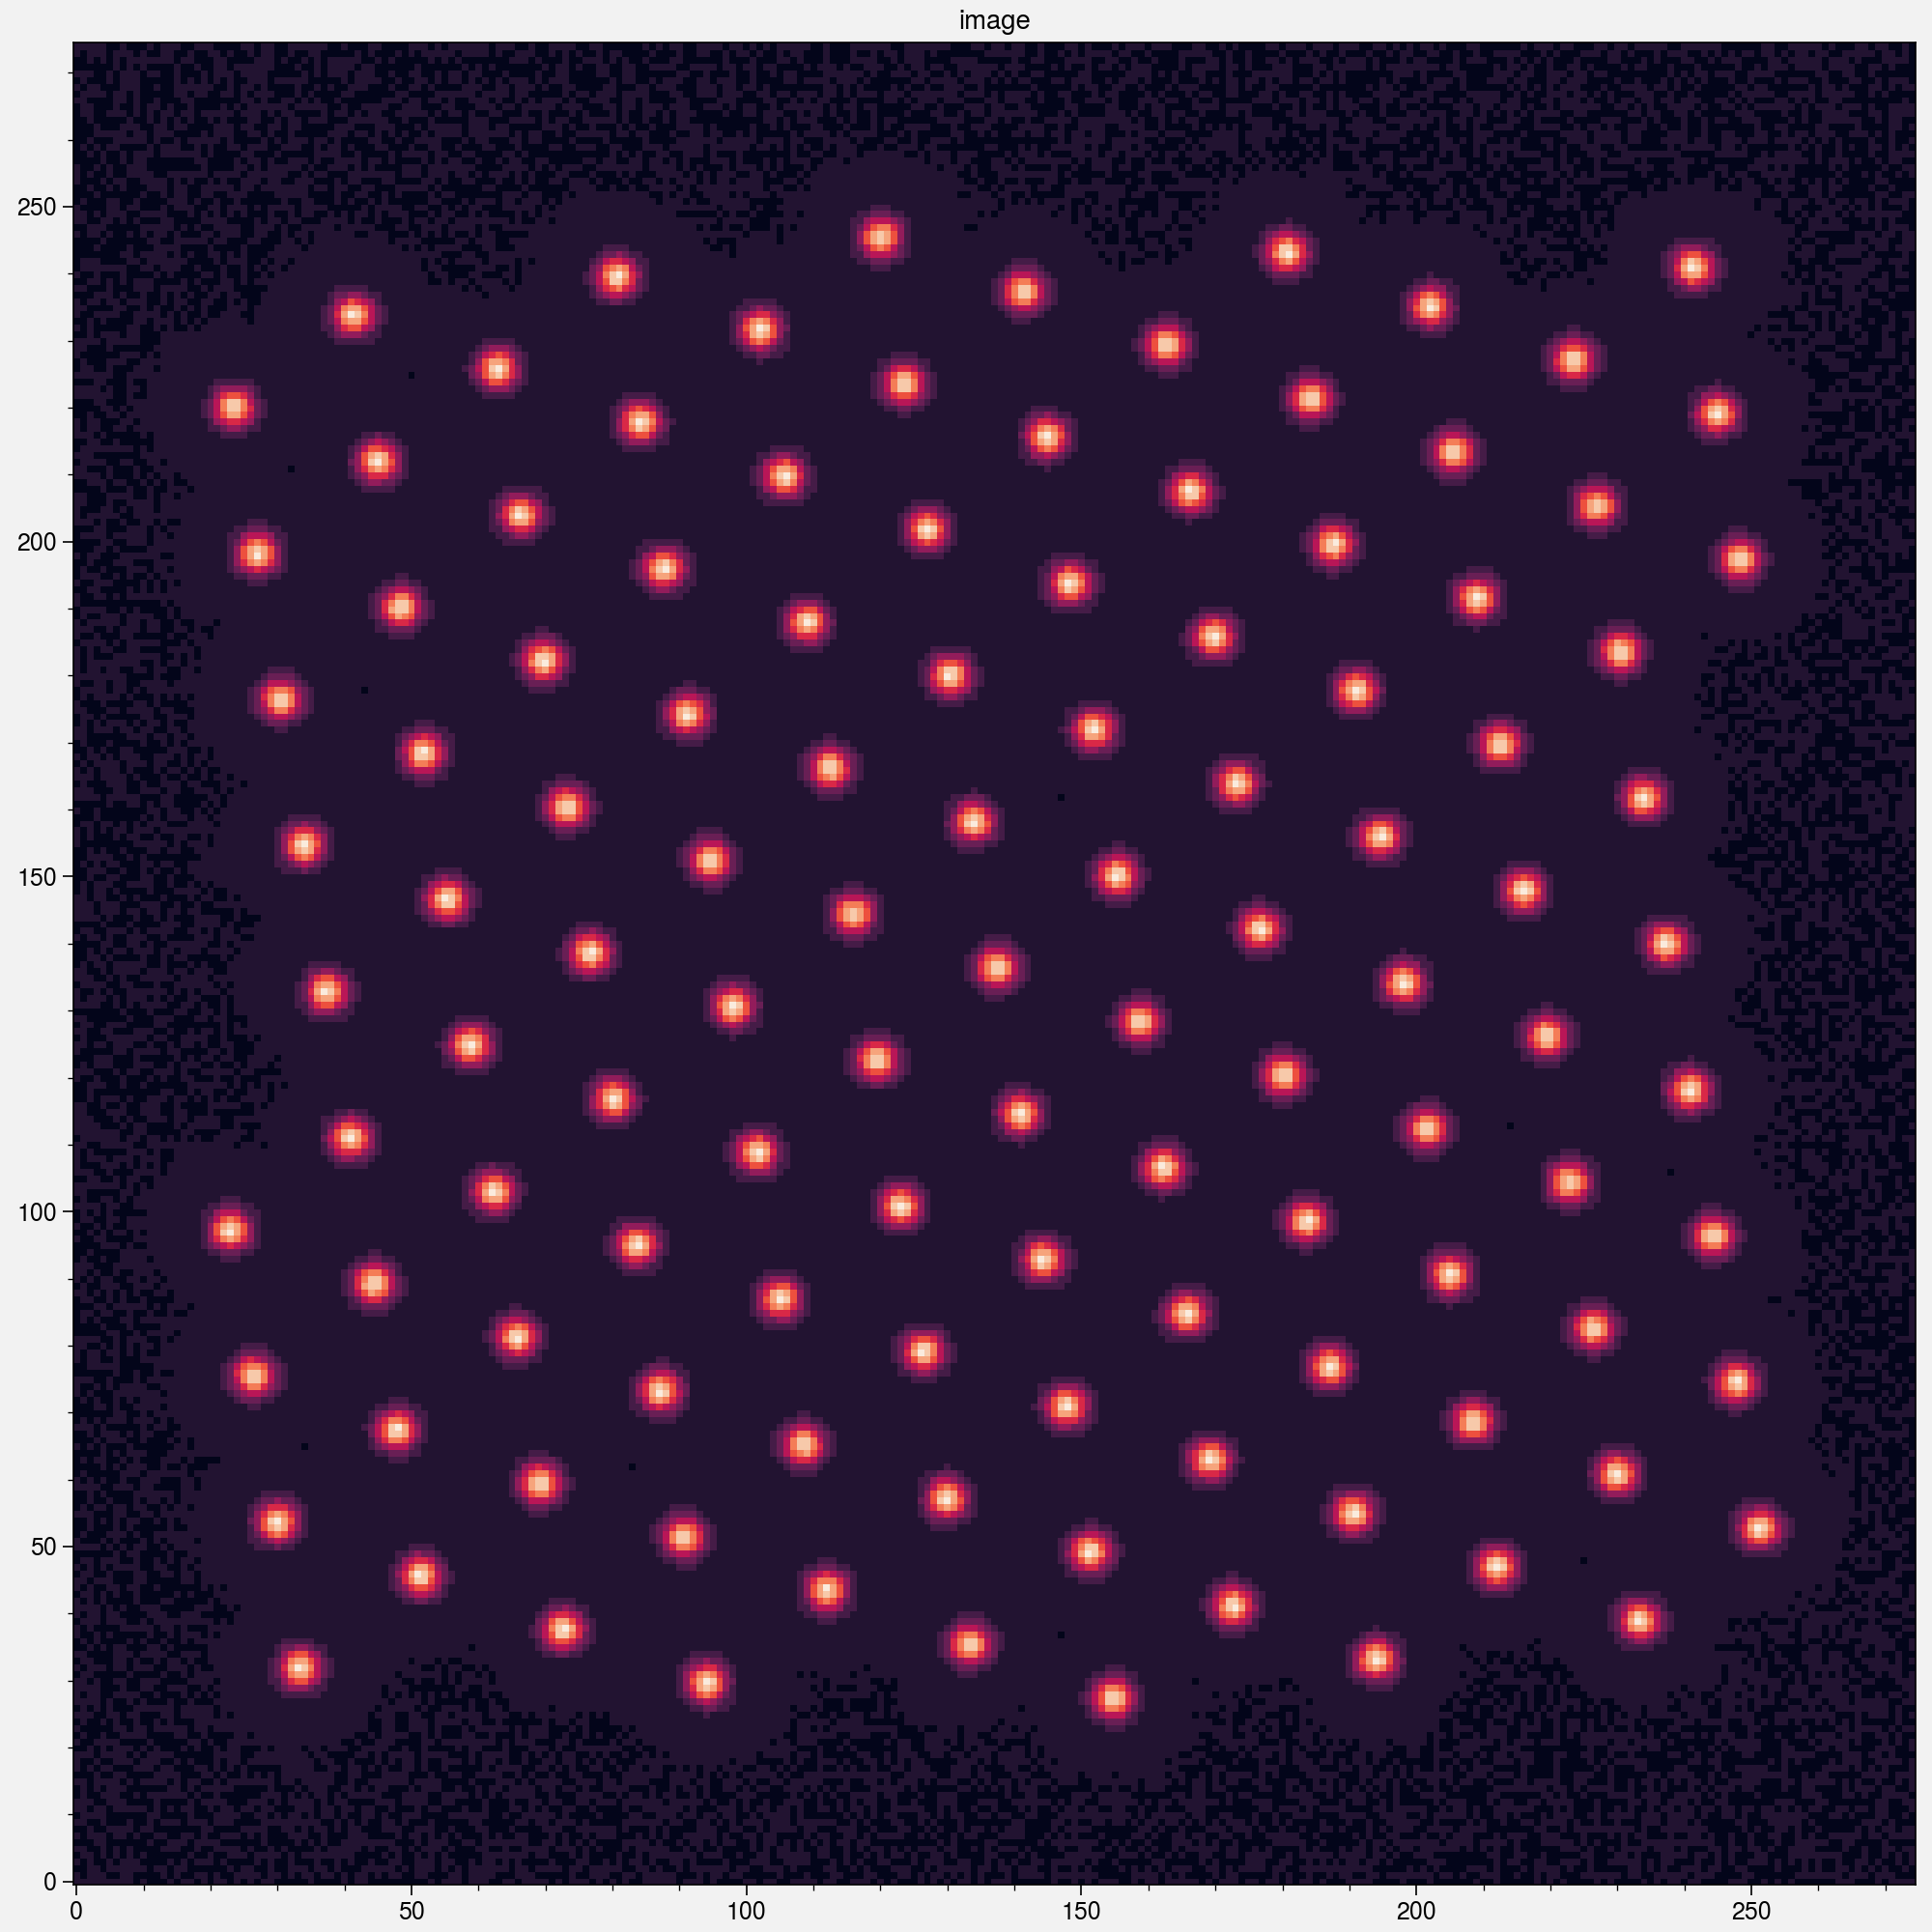

In [19]:
fig, axs = plot.subplots(figsize=(10, 10))
cdata = results["star"]

key = "image"
axs.pcolormesh(cdata[key], cmap="rocket")
axs.set_aspect(1)
axs.set_title(key)

In [20]:
res = run_metadetect(
    rng=mdet_rng,
    config=cfg["metadetect"],
    wcs=data["info"]["affine_wcs"],
    image=cdata["image"],
    bmask=cdata["bmask"],
    ormask=cdata["ormask"],
    noise=cdata["noise"],
    psf=cdata["psf"],
    weight=cdata["weight"],
    mfrac=cdata["mfrac"],
    mask_catalog=data["stars"],
    mask_expand_rad=cfg["star"]["mask_expand_rad"]
)

DEBUG:ngmix.fitting.leastsqbound:singular covariance
DEBUG:ngmix.fitting.leastsqbound:    pars at singular: -1.96e-09  -2.66e-08  -1.21e-08  1.29e-08     0.304         1 
DEBUG:ngmix.metacal.convenience:    Doing fixnoise with input noise image
DEBUG:metadetect.detect:box sizes: [64 64 32 48 64 64 64 64 64 32 48 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 48 64 48 64 64 64 64 64 64 64 64 64 64 64 64 64 64 48 48 64 64 64 64
 48 64 64 64 64 64 64 48 64 64 64 64 64 48 64 64 64 64 64 48 64 64 48 64
 64 64 64 64 64 64 32 64 64 64 64 64 64 64 48]
DEBUG:metadetect.detect:minmax: 32 64
DEBUG:metadetect.fitting:        wmom s2n: 21273.2 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21273.8 Trat: 1.48443
DEBUG:metadetect.fitting:        wmom s2n: 5636.45 Trat: 3.03434
DEBUG:metadetect.fitting:        wmom s2n: 21217 Trat: 1.488
DEBUG:metadetect.fitting:        wmom s2n: 21270.3 Trat: 1.48446
DEBUG:metadetect.fitting:        wmom s2n: 21271.9 Trat: 1.48464
DEBUG:metadetect.fitting:     

DEBUG:metadetect.fitting:        wmom s2n: 21268.5 Trat: 1.48456
DEBUG:metadetect.fitting:        wmom s2n: 21266.3 Trat: 1.48456
DEBUG:metadetect.fitting:        wmom s2n: 21268.9 Trat: 1.4846
DEBUG:metadetect.fitting:        wmom s2n: 21269.3 Trat: 1.48461
DEBUG:metadetect.fitting:        wmom s2n: 21269.8 Trat: 1.4846
DEBUG:metadetect.fitting:        wmom s2n: 21266.6 Trat: 1.48447
DEBUG:metadetect.fitting:        wmom s2n: 21269.1 Trat: 1.48462
DEBUG:metadetect.fitting:        wmom s2n: 21270.5 Trat: 1.48458
DEBUG:metadetect.fitting:        wmom s2n: 21269.1 Trat: 1.48456
DEBUG:metadetect.fitting:        wmom s2n: 21269.2 Trat: 1.48469
DEBUG:metadetect.fitting:        wmom s2n: 21267.4 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21267.7 Trat: 1.48461
DEBUG:metadetect.fitting:        wmom s2n: 21267.2 Trat: 1.48461
DEBUG:metadetect.fitting:        wmom s2n: 21269.2 Trat: 1.48451
DEBUG:metadetect.fitting:        wmom s2n: 21268.5 Trat: 1.48461
DEBUG:metadetect.fitting:  

DEBUG:metadetect.fitting:        wmom s2n: 21271.8 Trat: 1.48441
DEBUG:metadetect.fitting:        wmom s2n: 21275.6 Trat: 1.48459
DEBUG:metadetect.fitting:        wmom s2n: 21273.4 Trat: 1.48447
DEBUG:metadetect.fitting:        wmom s2n: 21273.8 Trat: 1.4845
DEBUG:metadetect.fitting:        wmom s2n: 21273.1 Trat: 1.48452
DEBUG:metadetect.fitting:        wmom s2n: 21276.1 Trat: 1.48449
DEBUG:metadetect.fitting:        wmom s2n: 21275.3 Trat: 1.48439
DEBUG:metadetect.fitting:        wmom s2n: 21274.4 Trat: 1.48449
DEBUG:metadetect.fitting:        wmom s2n: 10797.2 Trat: 2.31055
DEBUG:metadetect.fitting:        wmom s2n: 21273.7 Trat: 1.48439
DEBUG:metadetect.fitting:        wmom s2n: 21275.1 Trat: 1.48453
DEBUG:metadetect.fitting:        wmom s2n: 21274.5 Trat: 1.48451
DEBUG:metadetect.fitting:        wmom s2n: 21274.8 Trat: 1.48441
DEBUG:metadetect.fitting:        wmom s2n: 21039.5 Trat: 1.49876
DEBUG:metadetect.fitting:        wmom s2n: 21275.5 Trat: 1.48457
DEBUG:metadetect.fitting: 

DEBUG:metadetect.fitting:        wmom s2n: 21272.2 Trat: 1.48454
DEBUG:metadetect.fitting:        wmom s2n: 21273.5 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21269.5 Trat: 1.4846
DEBUG:metadetect.fitting:        wmom s2n: 21269.6 Trat: 1.48463
DEBUG:metadetect.fitting:        wmom s2n: 20773.4 Trat: 1.51498
DEBUG:metadetect.fitting:        wmom s2n: 21270 Trat: 1.4845
DEBUG:metadetect.fitting:        wmom s2n: 19687.3 Trat: 1.58363
DEBUG:metadetect.fitting:        wmom s2n: 21271.2 Trat: 1.48455
DEBUG:metadetect.fitting:        wmom s2n: 21270.6 Trat: 1.48449
DEBUG:metadetect.fitting:        wmom s2n: 8190.08 Trat: 2.63637
DEBUG:metadetect.metadetect:ormask|bmask region: 1|1
DEBUG:metadetect.detect:box sizes: [64 64 32 64 64 64 64 64 64 64 64 48 64 32 64 64 64 48 64 64 64 64 64 64
 64 48 64 48 64 64 64 64 48 48 64 64 64 64 64 64 64 64 64 64 48 64 64 64
 48 64 64 64 64 64 64 64 64 64 64 64 48 64 64 48 64 64 64 64 48 64 64 48
 64 64 64 64 64 64 64 64 64 64 64 64 32 48 48]


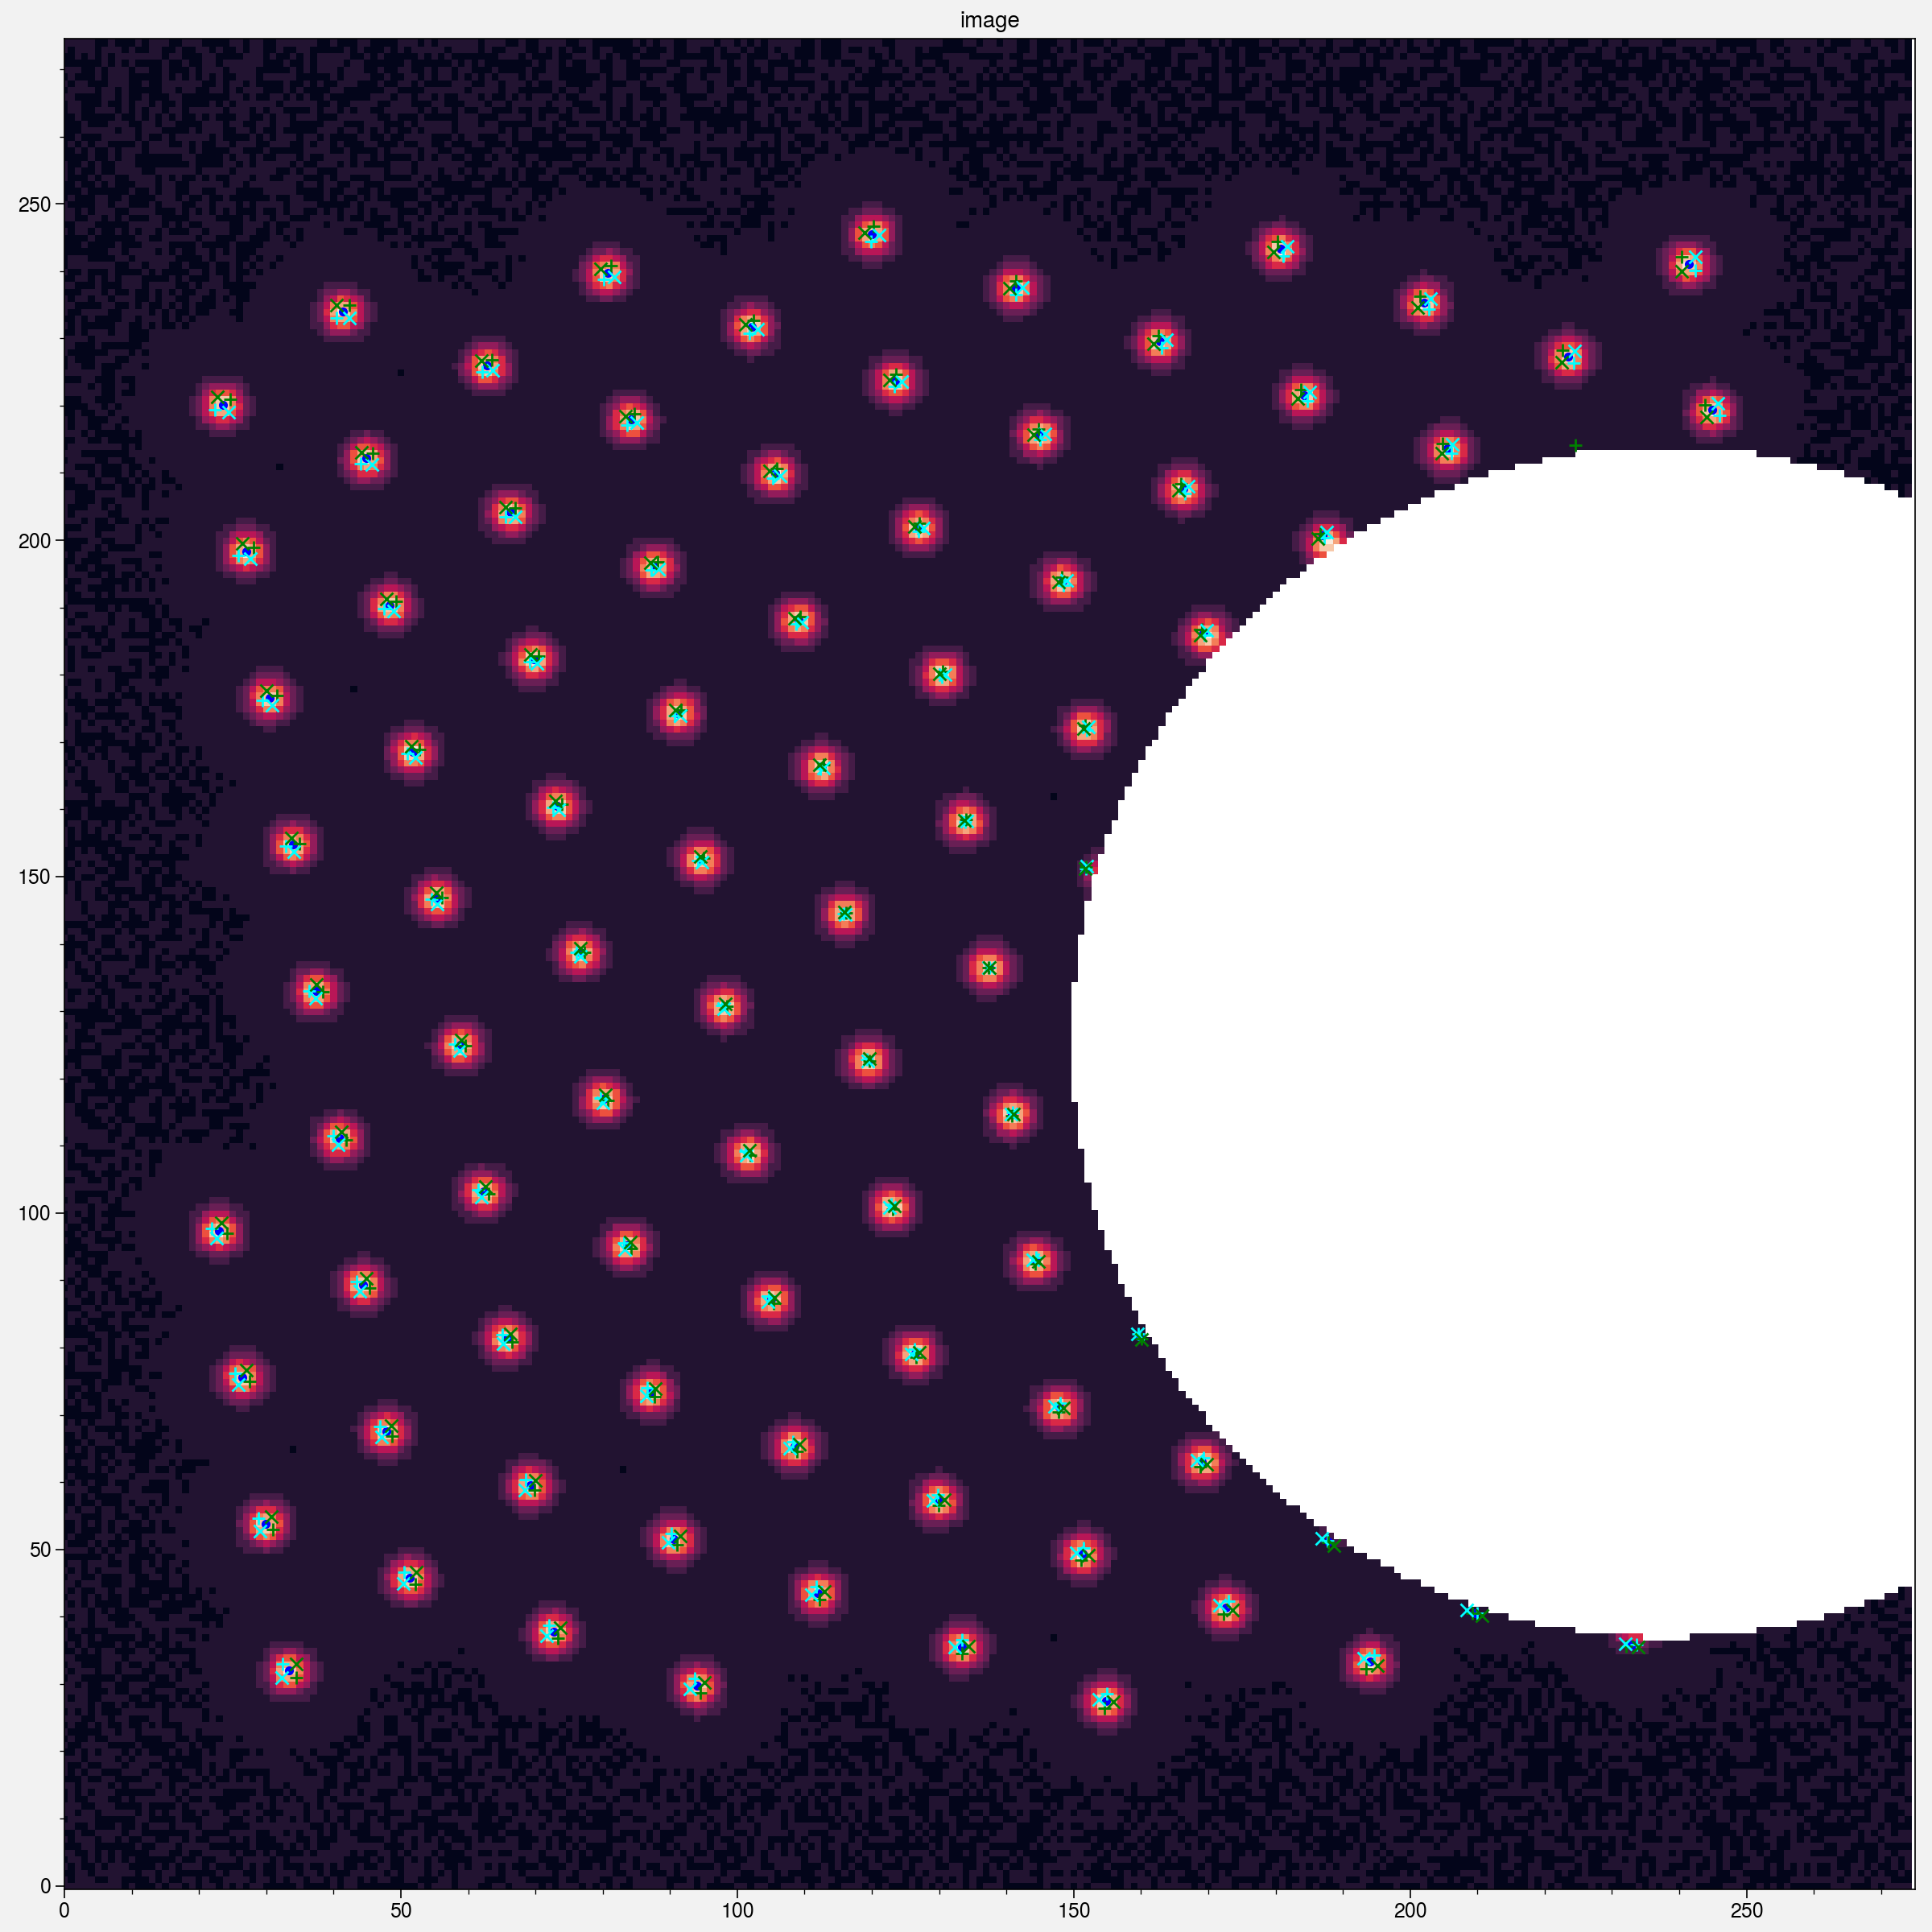

In [21]:
fig, axs = plot.subplots(figsize=(12, 12))
cdata = results["star"]

img = cdata[key].copy()
msk = cdata['mfrac'] == 1
img[msk] = np.nan

key = "image"
axs.pcolormesh(img, cmap="rocket")
axs.plot(res['noshear']['sx_col_noshear'], res['noshear']['sx_row_noshear'], 'b.')

axs.plot(res['1p']['sx_col'], res['1p']['sx_row'], '+', color='cyan')
axs.plot(res['1m']['sx_col'], res['1m']['sx_row'], '+', color='green')

axs.plot(res['2p']['sx_col'], res['2p']['sx_row'], 'x', color='cyan')
axs.plot(res['2m']['sx_col'], res['2m']['sx_row'], 'x', color='green')


axs.set_aspect(1)
axs.set_title(key)
axs.set_xlim(0, img.shape[1])

fig.savefig('star_sel.pdf')


In [22]:
for k in res:
    print(len(res[k]))

87
87
88
87
87
